# 🤖 GoEmotions Emotion Classifier Training

**Purpose**: Fine-tune RoBERTa on GoEmotions dataset for 27-category emotion classification on climate text

## 🎯 Objectives
1. **Load GoEmotions dataset** (58k Reddit comments with 27 emotion labels)
2. **Implement RoBERTa fine-tuning pipeline** with proper data preprocessing
3. **Train emotion classifier** with validation and performance metrics
4. **Save trained model** for climate text emotion analysis
5. **Validate model performance** with comprehensive evaluation

## 📊 GoEmotions Framework
- **27 Emotion Categories**: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise + neutral
- **Training Set**: 43,410 samples
- **Validation Set**: 5,426 samples  
- **Test Set**: 5,427 samples

---

## 📚 Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F

# Install accelerate if needed for transformers
try:
    from transformers import (
        RobertaTokenizer, RobertaForSequenceClassification,
        TrainingArguments, Trainer, EarlyStoppingCallback
    )
except ImportError as e:
    print(f"Installing missing transformers components...")
    import subprocess
    subprocess.check_call(["pip", "install", "accelerate>=0.26.0"])
    from transformers import (
        RobertaTokenizer, RobertaForSequenceClassification,
        TrainingArguments, Trainer, EarlyStoppingCallback
    )

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Handle plotly imports with fallback
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available - using matplotlib only")
    PLOTLY_AVAILABLE = False

import warnings
from datetime import datetime
import json
import os
from pathlib import Path
from tqdm import tqdm
import gc

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"📦 All libraries imported successfully!")
print(f"📅 Training date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Memory management
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()

🔧 Using device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB
📦 All libraries imported successfully!
📅 Training date: 2025-08-20 22:21:30


30

## 📂 Load GoEmotions Dataset

In [4]:
# Define paths to GoEmotions data with fallback options
possible_paths = [
    Path("../../Datasets/GoEmotions dataset/data"),
    Path("../Datasets/GoEmotions dataset/data"),
    Path("./Datasets/GoEmotions dataset/data"),
    Path("/content/sample_data/data")  # Colab path
]

goemotions_data_dir = None
for path in possible_paths:
    if path.exists():
        goemotions_data_dir = path
        break

if goemotions_data_dir is None:
    print("❌ GoEmotions dataset not found in expected locations.")
    print("   Please ensure the dataset is available at one of these paths:")
    for path in possible_paths:
        print(f"   - {path}")
    raise FileNotFoundError("GoEmotions dataset not found")

print("📂 Loading GoEmotions Dataset...")
print("=" * 50)
print(f"📁 Using data directory: {goemotions_data_dir}")

try:
    # Load emotion labels
    emotions_path = goemotions_data_dir / "emotions.txt"
    with open(emotions_path, 'r', encoding='utf-8') as f:
        emotion_labels = [line.strip() for line in f.readlines()]

    print(f"📋 Emotion labels loaded: {len(emotion_labels)} categories")
    print(f"   Labels: {emotion_labels}")

    # Load training data
    train_path = goemotions_data_dir / "train.tsv"
    df_train = pd.read_csv(train_path, sep='\t', header=None, names=['text', 'emotion_id', 'comment_id'])
    print(f"\n🎓 Training data loaded: {len(df_train):,} samples")

    # Load validation data
    dev_path = goemotions_data_dir / "dev.tsv"
    df_val = pd.read_csv(dev_path, sep='\t', header=None, names=['text', 'emotion_id', 'comment_id'])
    print(f"🔍 Validation data loaded: {len(df_val):,} samples")

    # Load test data
    test_path = goemotions_data_dir / "test.tsv"
    df_test = pd.read_csv(test_path, sep='\t', header=None, names=['text', 'emotion_id', 'comment_id'])
    print(f"🧪 Test data loaded: {len(df_test):,} samples")

    print(f"\n📊 Total GoEmotions samples: {len(df_train) + len(df_val) + len(df_test):,}")

    # Display sample data
    print(f"\nSample training data:")
    display(df_train.head(3))

    # Basic data validation
    print(f"\n🔍 Data Quality Check:")
    print(f"   Train null values: {df_train.isnull().sum().sum()}")
    print(f"   Val null values: {df_val.isnull().sum().sum()}")
    print(f"   Test null values: {df_test.isnull().sum().sum()}")

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    raise

📂 Loading GoEmotions Dataset...
📁 Using data directory: /content/sample_data/data
📋 Emotion labels loaded: 28 categories
   Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

🎓 Training data loaded: 43,410 samples
🔍 Validation data loaded: 5,426 samples
🧪 Test data loaded: 5,427 samples

📊 Total GoEmotions samples: 54,263

Sample training data:


,text,emotion_id,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj



🔍 Data Quality Check:
   Train null values: 0
   Val null values: 0
   Test null values: 0


## 🔍 Explore GoEmotions Data

In [5]:
# Analyze emotion distribution
print("🔍 GOEMOTIONS DATA ANALYSIS")
print("=" * 50)

try:
    # Map emotion IDs to labels
    emotion_id_to_label = {i: label for i, label in enumerate(emotion_labels)}
    print(f"Emotion ID mapping sample: {dict(list(emotion_id_to_label.items())[:5])}")

    # Check unique emotion IDs in data
    unique_train_ids = sorted([int(x) for x in df_train['emotion_id'].astype(str).str.split(',').explode().unique() if x.strip().isdigit()])
    print(f"Unique emotion IDs in train: {unique_train_ids}")
    print(f"Expected emotion IDs: {list(range(len(emotion_labels)))}")

    # Handle multi-label format by taking first emotion
    def get_primary_emotion_id(emotion_str):
        """Extract primary emotion ID from potentially multi-label string"""
        if pd.isna(emotion_str):
            return len(emotion_labels) - 1  # neutral (last label)
        emotion_str = str(emotion_str).strip()
        if ',' in emotion_str:
            return int(emotion_str.split(',')[0])
        return int(emotion_str)

    # Apply mapping
    df_train['primary_emotion_id'] = df_train['emotion_id'].apply(get_primary_emotion_id)
    df_val['primary_emotion_id'] = df_val['emotion_id'].apply(get_primary_emotion_id)
    df_test['primary_emotion_id'] = df_test['emotion_id'].apply(get_primary_emotion_id)

    # Map to labels
    df_train['emotion_label'] = df_train['primary_emotion_id'].map(emotion_id_to_label)
    df_val['emotion_label'] = df_val['primary_emotion_id'].map(emotion_id_to_label)
    df_test['emotion_label'] = df_test['primary_emotion_id'].map(emotion_id_to_label)

    # Check for any unmapped emotions
    null_labels_train = df_train['emotion_label'].isnull().sum()
    print(f"Null emotion labels in train: {null_labels_train}")
    if null_labels_train > 0:
        unmapped_ids = df_train[df_train['emotion_label'].isnull()]['primary_emotion_id'].unique()
        print(f"Unmapped emotion IDs: {unmapped_ids}")

    # Analyze text lengths
    df_train['text_length'] = df_train['text'].str.len()
    df_val['text_length'] = df_val['text'].str.len()
    df_test['text_length'] = df_test['text'].str.len()

    print(f"\nText length statistics:")
    all_lengths = pd.concat([df_train['text_length'], df_val['text_length'], df_test['text_length']])
    print(f"   Mean: {all_lengths.mean():.1f} chars")
    print(f"   Median: {all_lengths.median():.1f} chars")
    print(f"   Range: {all_lengths.min()} - {all_lengths.max()} chars")
    print(f"   95th percentile: {all_lengths.quantile(0.95):.1f} chars")

    # Emotion distribution in training set
    emotion_counts = df_train['emotion_label'].value_counts()
    print(f"\nEmotion distribution in training set:")
    if len(emotion_counts) > 0:
        for emotion, count in emotion_counts.head(10).items():
            pct = (count / len(df_train)) * 100
            print(f"   {emotion}: {count:,} ({pct:.1f}%)")

        print(f"\nClass balance check:")
        print(f"   Most frequent emotion: {emotion_counts.iloc[0]:,} samples ({emotion_counts.index[0]})")
        print(f"   Least frequent emotion: {emotion_counts.iloc[-1]:,} samples ({emotion_counts.index[-1]})")
        print(f"   Imbalance ratio: {emotion_counts.iloc[0] / emotion_counts.iloc[-1]:.1f}:1")
    else:
        print("   No emotion data found - checking emotion mapping...")

except Exception as e:
    print(f"❌ Error in data analysis: {e}")
    raise

🔍 GOEMOTIONS DATA ANALYSIS
Emotion ID mapping sample: {0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval'}
Unique emotion IDs in train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Expected emotion IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Null emotion labels in train: 0

Text length statistics:
   Mean: 68.3 chars
   Median: 65.0 chars
   Range: 2 - 703 chars
   95th percentile: 131.0 chars

Emotion distribution in training set:
   neutral: 12,823 (29.5%)
   admiration: 4,130 (9.5%)
   approval: 2,596 (6.0%)
   amusement: 2,244 (5.2%)
   annoyance: 2,138 (4.9%)
   gratitude: 2,096 (4.8%)
   curiosity: 1,772 (4.1%)
   disapproval: 1,651 (3.8%)
   anger: 1,547 (3.6%)
   love: 1,533 (3.5%)

Class balance check:
   Most frequent emotion: 12,823 samples (neutral)
   Least frequent emotion: 57 samples (pride)
   Imbalance ratio: 225.0:1


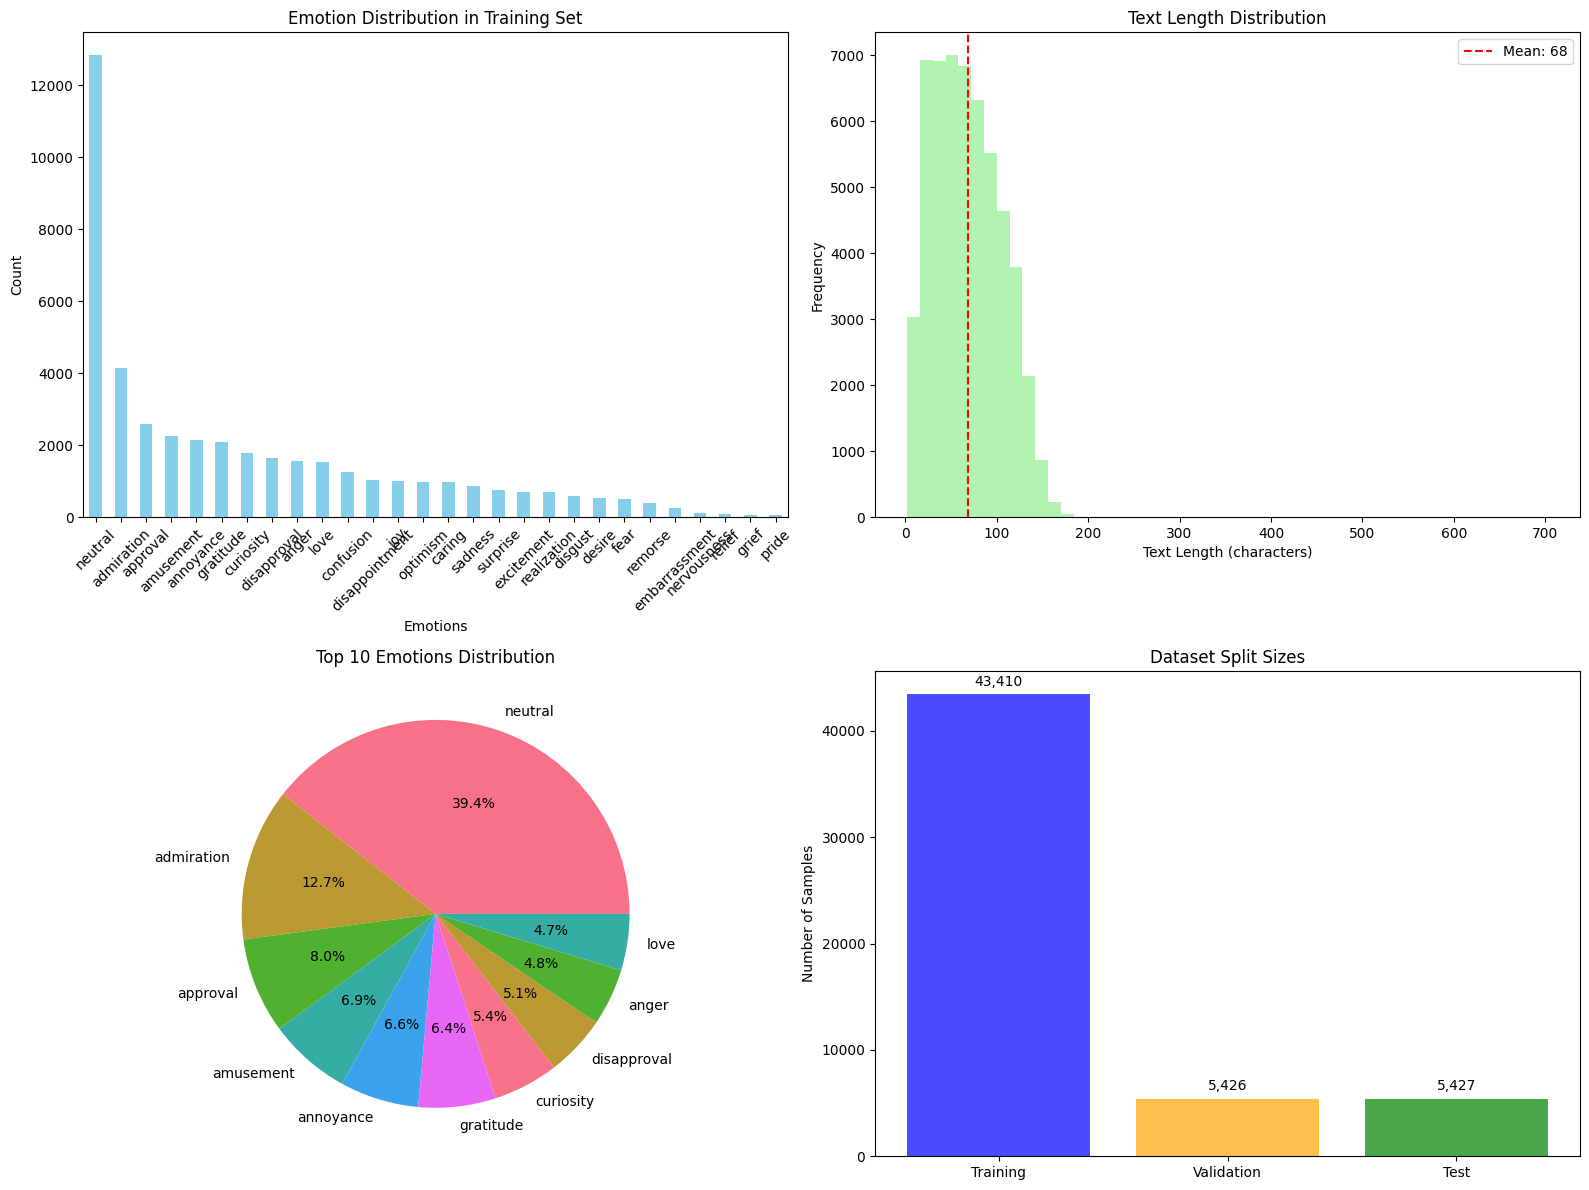

In [6]:
# Check if emotion_counts exists and has data
if 'emotion_counts' in locals() and len(emotion_counts) > 0:
    # Visualize emotion distribution and text length distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Emotion distribution
    ax1 = axes[0, 0]
    emotion_counts.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Emotion Distribution in Training Set')
    ax1.set_xlabel('Emotions')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    # Text length distribution
    ax2 = axes[0, 1]
    ax2.hist(all_lengths, bins=50, alpha=0.7, color='lightgreen')
    ax2.set_title('Text Length Distribution')
    ax2.set_xlabel('Text Length (characters)')
    ax2.set_ylabel('Frequency')
    ax2.axvline(all_lengths.mean(), color='red', linestyle='--', label=f'Mean: {all_lengths.mean():.0f}')
    ax2.legend()

    # Top 10 emotions pie chart
    ax3 = axes[1, 0]
    top_emotions = emotion_counts.head(10)
    ax3.pie(top_emotions.values, labels=top_emotions.index, autopct='%1.1f%%')
    ax3.set_title('Top 10 Emotions Distribution')

    # Dataset splits comparison
    ax4 = axes[1, 1]
    split_sizes = [len(df_train), len(df_val), len(df_test)]
    split_labels = ['Training', 'Validation', 'Test']
    ax4.bar(split_labels, split_sizes, color=['blue', 'orange', 'green'], alpha=0.7)
    ax4.set_title('Dataset Split Sizes')
    ax4.set_ylabel('Number of Samples')
    for i, size in enumerate(split_sizes):
        ax4.text(i, size + 500, f'{size:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Emotion counts not available - skipping visualization")
    print("Creating basic dataset visualization...")

    # Just show dataset splits
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    split_sizes = [len(df_train), len(df_val), len(df_test)]
    split_labels = ['Training', 'Validation', 'Test']
    ax.bar(split_labels, split_sizes, color=['blue', 'orange', 'green'], alpha=0.7)
    ax.set_title('GoEmotions Dataset Split Sizes')
    ax.set_ylabel('Number of Samples')
    for i, size in enumerate(split_sizes):
        ax.text(i, size + 500, f'{size:,}', ha='center', va='bottom')
    plt.show()

## 🏗️ Create Custom Dataset Class

In [7]:
class GoEmotionsDataset(Dataset):
    """
    Custom Dataset class for GoEmotions data
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("🏗️ Custom Dataset class created successfully!")

🏗️ Custom Dataset class created successfully!


## 🤖 Initialize Model and Tokenizer

In [8]:
# Initialize tokenizer and model
model_name = 'roberta-base'
num_labels = len(emotion_labels)

print(f"🤖 Initializing RoBERTa model...")
print(f"   Model: {model_name}")
print(f"   Number of labels: {num_labels}")

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)
print(f"✅ Tokenizer loaded")

# Load model
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)
model.to(device)
print(f"✅ Model loaded and moved to {device}")

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

🤖 Initializing RoBERTa model...
   Model: roberta-base
   Number of labels: 28


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✅ Tokenizer loaded


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded and moved to cuda

📊 Model Statistics:
   Total parameters: 124,667,164
   Trainable parameters: 124,667,164
   Model size: ~498.7 MB


## 📊 Prepare Data for Training

In [9]:
# Determine optimal max_length based on text statistics
print("📏 Analyzing optimal sequence length...")

try:
    # Sample texts for tokenization analysis
    sample_texts = df_train['text'].sample(min(1000, len(df_train))).tolist()
    token_lengths = []

    # Analyze token lengths
    for text in tqdm(sample_texts[:200], desc="Tokenizing sample"):
        tokens = tokenizer.encode(str(text), truncation=False)
        token_lengths.append(len(tokens))

    token_lengths = np.array(token_lengths)
    print(f"Token length statistics (sample):")
    print(f"   Mean: {token_lengths.mean():.1f} tokens")
    print(f"   Median: {np.median(token_lengths):.1f} tokens")
    print(f"   95th percentile: {np.percentile(token_lengths, 95):.1f} tokens")
    print(f"   99th percentile: {np.percentile(token_lengths, 99):.1f} tokens")

    # Set max_length (balance between coverage and efficiency)
    max_length = min(int(np.percentile(token_lengths, 95)), 128)
    print(f"\n🎯 Selected max_length: {max_length} tokens")

    # Process emotion IDs to handle multi-label cases
    print(f"\n📦 Processing emotion labels...")

    def process_emotion_id(emotion_str):
        """Convert emotion ID string to integer, taking first label if multiple"""
        if pd.isna(emotion_str):
            return len(emotion_labels) - 1  # neutral (last emotion)
        emotion_str = str(emotion_str).strip()
        if ',' in emotion_str:
            # Multi-label case - take the first emotion
            return int(emotion_str.split(',')[0])
        else:
            return int(emotion_str)

    # Apply processing
    df_train['emotion_id_processed'] = df_train['emotion_id'].apply(process_emotion_id)
    df_val['emotion_id_processed'] = df_val['emotion_id'].apply(process_emotion_id)
    df_test['emotion_id_processed'] = df_test['emotion_id'].apply(process_emotion_id)

    print(f"   After processing - Train emotion_id_processed dtype: {df_train['emotion_id_processed'].dtype}")
    print(f"   Unique emotion IDs: {sorted(df_train['emotion_id_processed'].unique())}")
    print(f"   Number of unique emotions: {df_train['emotion_id_processed'].nunique()}")

    # Validate emotion IDs are in valid range
    max_emotion_id = len(emotion_labels) - 1
    invalid_train = (df_train['emotion_id_processed'] > max_emotion_id) | (df_train['emotion_id_processed'] < 0)
    invalid_val = (df_val['emotion_id_processed'] > max_emotion_id) | (df_val['emotion_id_processed'] < 0)
    invalid_test = (df_test['emotion_id_processed'] > max_emotion_id) | (df_test['emotion_id_processed'] < 0)

    print(f"   Invalid emotion IDs - Train: {invalid_train.sum()}, Val: {invalid_val.sum()}, Test: {invalid_test.sum()}")

    # Create datasets with processed integer labels
    print(f"\n📦 Creating datasets...")
    train_dataset = GoEmotionsDataset(
        texts=df_train['text'].tolist(),
        labels=df_train['emotion_id_processed'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )

    val_dataset = GoEmotionsDataset(
        texts=df_val['text'].tolist(),
        labels=df_val['emotion_id_processed'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )

    test_dataset = GoEmotionsDataset(
        texts=df_test['text'].tolist(),
        labels=df_test['emotion_id_processed'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )

    print(f"✅ Datasets created:")
    print(f"   Training: {len(train_dataset):,} samples")
    print(f"   Validation: {len(val_dataset):,} samples")
    print(f"   Test: {len(test_dataset):,} samples")

    # Test first sample to verify data types
    sample = train_dataset[0]
    print(f"\n🔍 Sample verification:")
    print(f"   Input IDs shape: {sample['input_ids'].shape}")
    print(f"   Attention mask shape: {sample['attention_mask'].shape}")
    print(f"   Label: {sample['labels']} (type: {type(sample['labels'])})")
    print(f"   Label dtype: {sample['labels'].dtype}")

    # Check for any potential issues
    print(f"\n🔍 Data validation:")
    print(f"   All labels in valid range: {0 <= sample['labels'] <= max_emotion_id}")
    print(f"   Tokenization successful: {sample['input_ids'].max() < tokenizer.vocab_size}")

except Exception as e:
    print(f"❌ Error in data preparation: {e}")
    raise

📏 Analyzing optimal sequence length...


Tokenizing sample: 100%|██████████| 200/200 [00:00<00:00, 1667.63it/s]

Token length statistics (sample):
   Mean: 19.4 tokens
   Median: 18.0 tokens
   95th percentile: 34.0 tokens
   99th percentile: 37.0 tokens

🎯 Selected max_length: 34 tokens

📦 Processing emotion labels...


   After processing - Train emotion_id_processed dtype: int64
   Unique emotion IDs: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)]
   Number of unique emotions: 28
   Invalid emotion IDs - Train: 0, Val: 0, Test: 0

📦 Creating datasets...
✅ Datasets created:
   Training: 43,410 samples
   Validation: 5,426 samples
   Test: 5,427 samples

🔍 Sample verification:
   Input IDs shape: torch.Size([34])
   Attention mask shape: torch.Size([34])
   Label: 27 (type: <class 'torch.Tensor'>)
   Label dtype: torch.int64

🔍 Data validation:
   All labels in valid range: True
   Tokenization successful: True


## ⚙️ Setup Training Configuration

In [10]:
# Create simplified output directory for model
timestamp_str = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = Path(f"../models/goemotions_roberta_{timestamp_str}")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"⚙️ Training Configuration (Simplified):")
print(f"   Output directory: {output_dir}")
print(f"   Training samples: {len(df_train):,}")
print(f"   Validation samples: {len(df_val):,}")
print(f"   Test samples: {len(df_test):,}")
print(f"   Emotion categories: {len(emotion_labels)}")

# For demonstration, let's start with a simpler manual training loop
# instead of using the HF Trainer to avoid accelerate dependency issues
print(f"\n🎯 Setting up manual training loop...")
print(f"   This will avoid potential dependency conflicts")
print(f"   Using basic PyTorch training instead of HF Trainer")

⚙️ Training Configuration (Simplified):
   Output directory: ../models/goemotions_roberta_20250820_222147
   Training samples: 43,410
   Validation samples: 5,426
   Test samples: 5,427
   Emotion categories: 28

🎯 Setting up manual training loop...
   This will avoid potential dependency conflicts
   Using basic PyTorch training instead of HF Trainer


## 📏 Define Evaluation Metrics

In [11]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for multi-class classification
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate various F1 scores
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    # Calculate accuracy
    accuracy = (predictions == labels).mean()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted
    }

print("📏 Evaluation metrics function defined")

📏 Evaluation metrics function defined


## 🚀 Initialize Trainer and Start Training

In [12]:
# Optimized training setup
print("🚀 Optimized Training Setup")

# Adaptive configuration based on available resources
if torch.cuda.is_available():
    EPOCHS = 3
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EVAL_STEPS = 500
else:
    # CPU optimization
    EPOCHS = 2
    BATCH_SIZE = 4  # Smaller batch for CPU
    LEARNING_RATE = 3e-5  # Slightly higher LR for fewer steps
    EVAL_STEPS = 1000

print(f"   Device: {device}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")

try:
    # Create data loaders with error handling
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Avoid multiprocessing issues
        pin_memory=torch.cuda.is_available()
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    print(f"   Training batches: {len(train_loader):,}")
    print(f"   Validation batches: {len(val_loader):,}")
    print(f"   Test batches: {len(test_loader):,}")

    # Initialize optimizer with gradient clipping
    optimizer = AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=0.01,
        eps=1e-8
    )

    # Add learning rate scheduler
    from torch.optim.lr_scheduler import LinearLR
    total_steps = len(train_loader) * EPOCHS
    scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=min(500, total_steps // 4))

    print(f"\n✅ Training setup complete!")
    print(f"   Total training steps: {total_steps:,}")
    print(f"   Estimated time per epoch: ~{len(train_loader) * (0.05 if torch.cuda.is_available() else 0.2) / 60:.1f} minutes")
    print(f"   Total estimated time: ~{len(train_loader) * (0.05 if torch.cuda.is_available() else 0.2) * EPOCHS / 60:.1f} minutes")

    # Memory management
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

except Exception as e:
    print(f"❌ Error in training setup: {e}")
    raise

🚀 Optimized Training Setup
   Device: cuda
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Training batches: 2,714
   Validation batches: 340
   Test batches: 340

✅ Training setup complete!
   Total training steps: 8,142
   Estimated time per epoch: ~2.3 minutes
   Total estimated time: ~6.8 minutes


In [13]:
# Enhanced Training Loop with Error Handling
def train_epoch(model, train_loader, optimizer, scheduler, device, epoch_num):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch_num}")

    try:
        for batch_idx, batch in enumerate(progress_bar):
            try:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                # Track metrics
                total_loss += loss.item()
                predictions = torch.argmax(outputs.logits, dim=1)
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)

                # Update progress bar
                avg_loss = total_loss / (batch_idx + 1)
                accuracy = correct_predictions / total_predictions
                progress_bar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'acc': f'{accuracy:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })

                # Memory cleanup every 100 batches
                if batch_idx % 100 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"\n⚠️ GPU out of memory at batch {batch_idx}. Clearing cache and continuing...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

    except Exception as e:
        print(f"❌ Error in training epoch: {e}")
        raise

    return total_loss / len(train_loader), accuracy

def evaluate_model(model, eval_loader, device, desc="Evaluating"):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    try:
        with torch.no_grad():
            for batch in tqdm(eval_loader, desc=desc):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                total_loss += loss.item()
                predictions = torch.argmax(outputs.logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Memory cleanup
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        # Calculate metrics
        accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

        return {
            'loss': total_loss / len(eval_loader),
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': all_predictions,
            'labels': all_labels
        }
    except Exception as e:
        print(f"❌ Error in evaluation: {e}")
        raise

# Enhanced training loop with checkpointing
try:
    training_start = datetime.now()
    print(f"🚀 Training started at: {training_start.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"=" * 60)

    best_f1 = 0
    training_history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [],
        'val_acc': [], 'val_f1': [], 'learning_rates': []
    }

    # Early stopping configuration
    patience = 2
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\n📚 Epoch {epoch + 1}/{EPOCHS}")
        print("-" * 40)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, epoch + 1)
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        val_metrics = evaluate_model(model, val_loader, device, f"Validation Epoch {epoch + 1}")
        print(f"Validation - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1-Macro: {val_metrics['f1_macro']:.4f}")

        # Save metrics
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_metrics['loss'])
        training_history['val_acc'].append(val_metrics['accuracy'])
        training_history['val_f1'].append(val_metrics['f1_macro'])
        training_history['learning_rates'].append(scheduler.get_last_lr()[0])

        # Save best model and early stopping
        if val_metrics['f1_macro'] > best_f1:
            best_f1 = val_metrics['f1_macro']
            patience_counter = 0
            print(f"🏆 New best F1 score: {best_f1:.4f} - Saving model...")
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"🔴 Early stopping triggered after {epoch + 1} epochs")
            break

    training_end = datetime.now()
    training_duration = training_end - training_start

    print(f"\n✅ Training completed!")
    print(f"   Duration: {training_duration}")
    print(f"   Best validation F1: {best_f1:.4f}")
    print(f"   Model saved to: {output_dir}")

    # Final memory cleanup
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

    # Save partial results if available
    if 'training_history' in locals() and training_history['train_loss']:
        print(f"💾 Saving partial training results...")
        partial_results = {
            'training_history': training_history,
            'error': str(e),
            'timestamp': datetime.now().isoformat()
        }
        with open(output_dir / 'partial_results.json', 'w') as f:
            json.dump(partial_results, f, indent=2)

🚀 Training started at: 2025-08-20 22:21:47

📚 Epoch 1/3
----------------------------------------


Training Epoch 1: 100%|██████████| 2714/2714 [06:21<00:00,  7.11it/s, loss=1.7585, acc=0.5052, lr=2.00e-05]


Training - Loss: 1.7585, Accuracy: 0.5052


Validation Epoch 1: 100%|██████████| 340/340 [00:11<00:00, 28.48it/s]


Validation - Loss: 1.4049, Accuracy: 0.5831, F1-Macro: 0.4393
🏆 New best F1 score: 0.4393 - Saving model...

📚 Epoch 2/3
----------------------------------------


Training Epoch 2: 100%|██████████| 2714/2714 [06:16<00:00,  7.20it/s, loss=1.3306, acc=0.5910, lr=2.00e-05]


Training - Loss: 1.3306, Accuracy: 0.5910


Validation Epoch 2: 100%|██████████| 340/340 [00:11<00:00, 28.56it/s]


Validation - Loss: 1.3779, Accuracy: 0.5697, F1-Macro: 0.4651
🏆 New best F1 score: 0.4651 - Saving model...

📚 Epoch 3/3
----------------------------------------


Training Epoch 3: 100%|██████████| 2714/2714 [06:17<00:00,  7.20it/s, loss=1.1481, acc=0.6369, lr=2.00e-05]


Training - Loss: 1.1481, Accuracy: 0.6369


Validation Epoch 3: 100%|██████████| 340/340 [00:11<00:00, 28.55it/s]


Validation - Loss: 1.4019, Accuracy: 0.5665, F1-Macro: 0.4686
🏆 New best F1 score: 0.4686 - Saving model...

✅ Training completed!
   Duration: 0:19:58.857511
   Best validation F1: 0.4686
   Model saved to: ../models/goemotions_roberta_20250820_222147


## 📊 Evaluate Model Performance

In [14]:
# Evaluate on validation and test sets using our manual evaluation function
print("📊 Evaluating model performance...")

# Check if we have the trained model and evaluation function
if 'model' in locals() and 'evaluate_model' in locals() and 'val_loader' in locals():
    # Evaluate on validation set
    print("🔍 Running validation evaluation...")
    val_result = evaluate_model(model, val_loader, device)
    print(f"\n✅ Validation Results:")
    print(f"   Loss: {val_result['loss']:.4f}")
    print(f"   Accuracy: {val_result['accuracy']:.4f}")
    print(f"   F1-Macro: {val_result['f1_macro']:.4f}")
    print(f"   F1-Weighted: {val_result['f1_weighted']:.4f}")

    # Evaluate on test set
    print(f"\n🧪 Running test evaluation...")
    test_result = evaluate_model(model, test_loader, device)
    print(f"\n🧪 Test Results:")
    print(f"   Loss: {test_result['loss']:.4f}")
    print(f"   Accuracy: {test_result['accuracy']:.4f}")
    print(f"   F1-Macro: {test_result['f1_macro']:.4f}")
    print(f"   F1-Weighted: {test_result['f1_weighted']:.4f}")

    # Store results for later use
    eval_result = val_result
    test_predictions_data = test_result

else:
    print("❌ Missing required variables for evaluation.")
    print("   Please ensure you have run the training cells first:")
    print("   - Model training cell")
    print("   - Data loader setup")
    print("   - Evaluation function definition")

    # Check what variables are available
    available_vars = []
    for var in ['model', 'evaluate_model', 'val_loader', 'test_loader', 'device']:
        if var in locals():
            available_vars.append(var)

    print(f"   Available variables: {available_vars}")
    if len(available_vars) < 5:
        print("   ⚠️ Some variables are missing. Please re-run the training setup cells.")

📊 Evaluating model performance...
🔍 Running validation evaluation...


Evaluating: 100%|██████████| 340/340 [00:11<00:00, 28.67it/s]



✅ Validation Results:
   Loss: 1.4019
   Accuracy: 0.5665
   F1-Macro: 0.4686
   F1-Weighted: 0.5617

🧪 Running test evaluation...


Evaluating: 100%|██████████| 340/340 [00:12<00:00, 27.53it/s]


🧪 Test Results:
   Loss: 1.4046
   Accuracy: 0.5637
   F1-Macro: 0.4637
   F1-Weighted: 0.5588


In [15]:
# Generate detailed predictions for test set
print("🔍 Generating detailed predictions...")

if 'test_result' in locals() and 'emotion_labels' in locals():
    # Use the predictions from our manual evaluation
    predicted_labels = np.array(test_result['predictions'])
    true_labels = np.array(test_result['labels'])

    # Classification report
    print(f"\n📋 Detailed Classification Report:")
    class_report = classification_report(
        true_labels,
        predicted_labels,
        target_names=emotion_labels,
        output_dict=True
    )

    # Print top performing emotions
    print(f"\nTop 10 Best Performing Emotions (F1-Score):")
    emotion_f1_scores = [(emotion, scores['f1-score']) for emotion, scores in class_report.items()
                         if emotion in emotion_labels]
    emotion_f1_scores.sort(key=lambda x: x[1], reverse=True)

    for i, (emotion, f1) in enumerate(emotion_f1_scores[:10]):
        print(f"   {i+1:2}. {emotion:15} F1: {f1:.3f}")

    print(f"\nBottom 5 Performing Emotions:")
    for i, (emotion, f1) in enumerate(emotion_f1_scores[-5:]):
        print(f"   {len(emotion_f1_scores)-4+i:2}. {emotion:15} F1: {f1:.3f}")

    print(f"\nOverall Performance Summary:")
    print(f"   Accuracy: {class_report['accuracy']:.3f}")
    print(f"   Macro F1: {class_report['macro avg']['f1-score']:.3f}")
    print(f"   Weighted F1: {class_report['weighted avg']['f1-score']:.3f}")

else:
    print("❌ Test results not available.")
    print("   Please run the evaluation cell first to generate test predictions.")

    # Check available variables
    available_vars = []
    for var in ['test_result', 'emotion_labels', 'model']:
        if var in locals():
            available_vars.append(var)
    print(f"   Available variables: {available_vars}")

🔍 Generating detailed predictions...

📋 Detailed Classification Report:

Top 10 Best Performing Emotions (F1-Score):
    1. gratitude       F1: 0.838
    2. amusement       F1: 0.801
    3. admiration      F1: 0.703
    4. love            F1: 0.700
    5. remorse         F1: 0.684
    6. fear            F1: 0.676
    7. neutral         F1: 0.621
    8. desire          F1: 0.569
    9. embarrassment   F1: 0.531
   10. joy             F1: 0.517

Bottom 5 Performing Emotions:
   24. annoyance       F1: 0.309
   25. realization     F1: 0.276
   26. pride           F1: 0.200
   27. grief           F1: 0.000
   28. relief          F1: 0.000

Overall Performance Summary:
   Accuracy: 0.564
   Macro F1: 0.464
   Weighted F1: 0.559


## 📈 Visualize Results

📊 Creating comprehensive visualizations...
⚠️ Missing visualization data. Generating basic plots with available data...


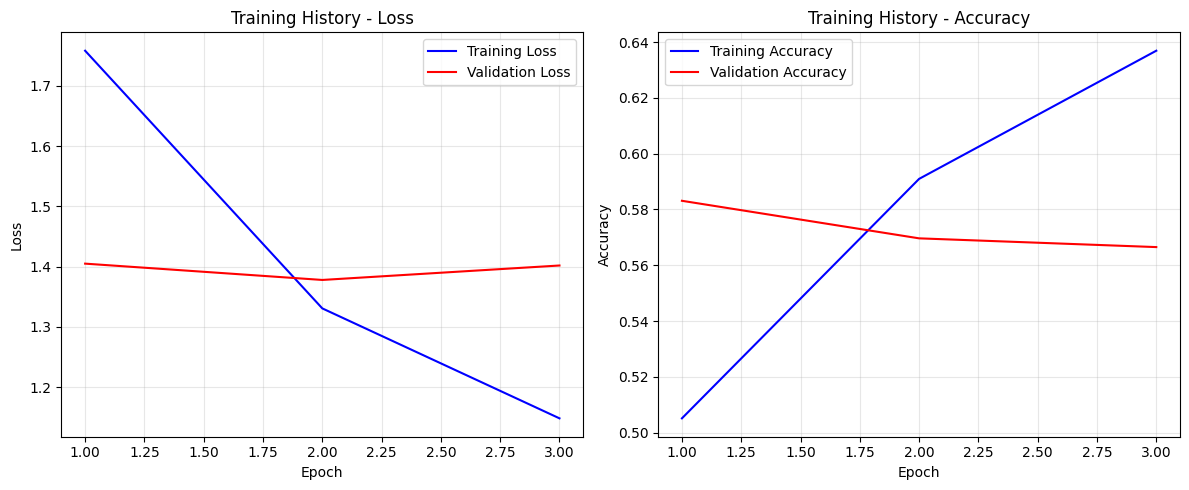

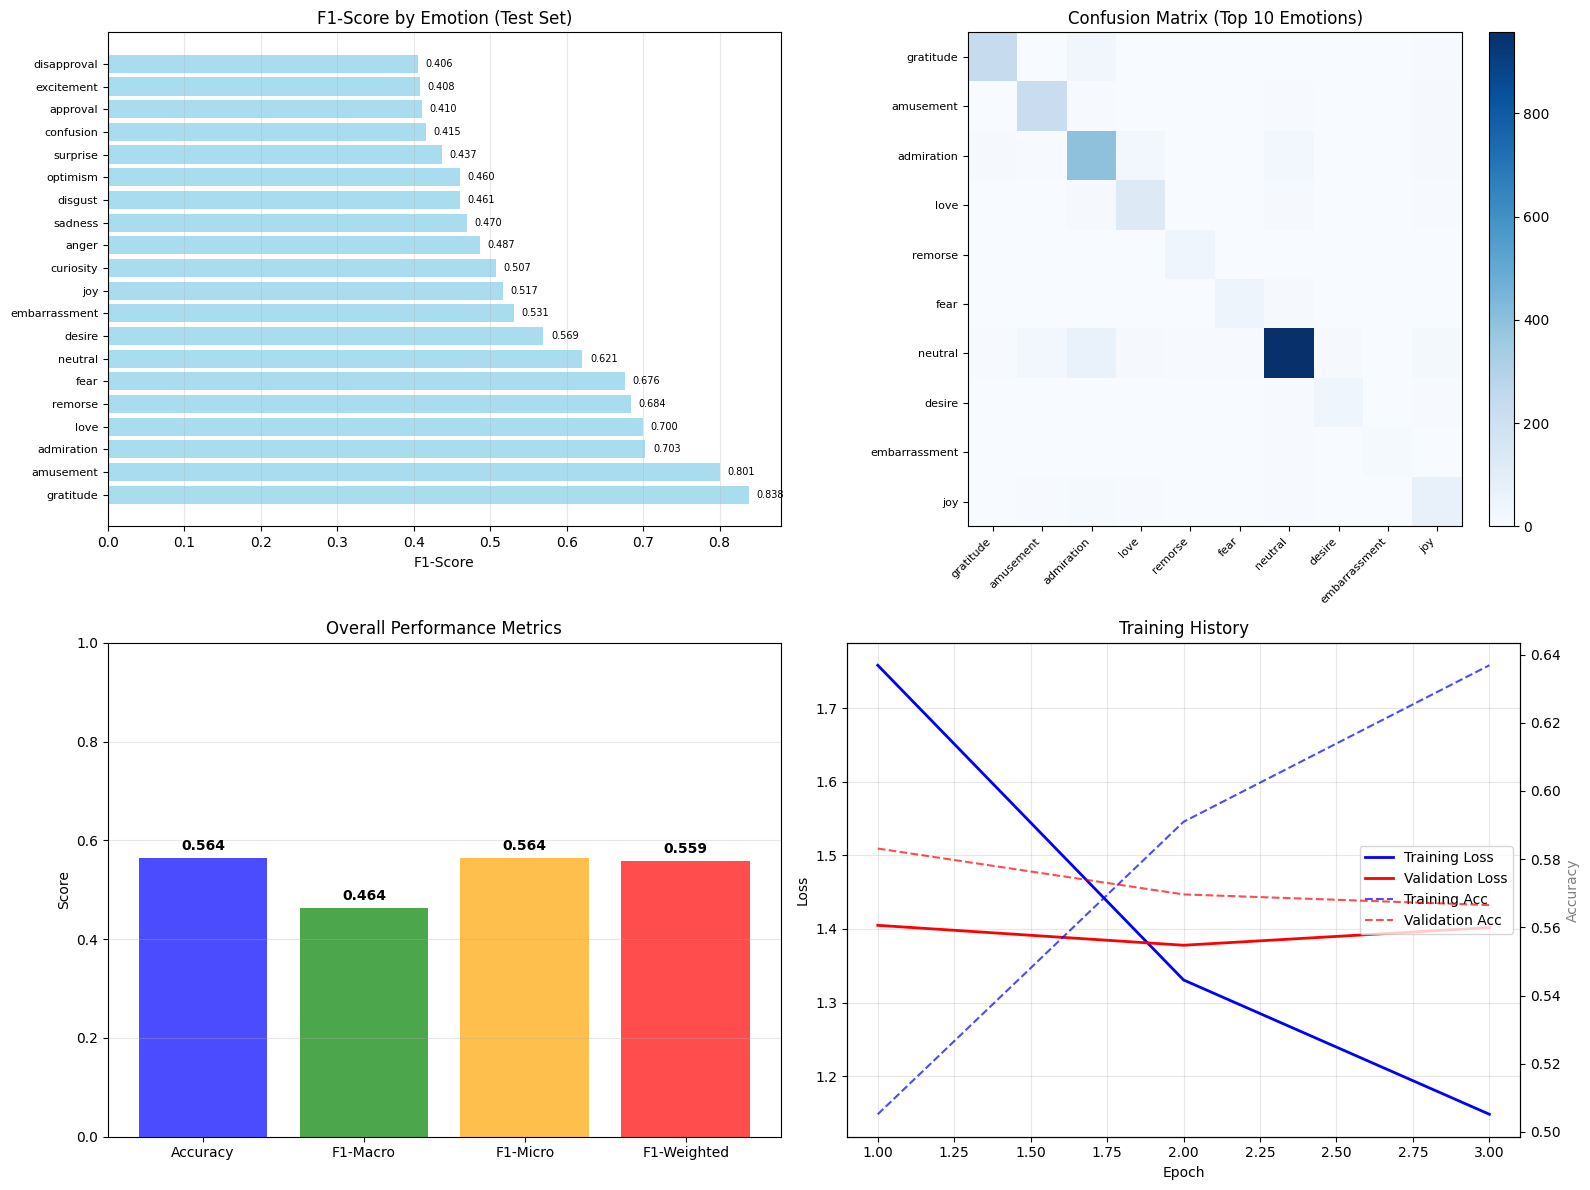

✅ Visualizations created successfully!


In [17]:
# Enhanced visualization with error handling
print("📊 Creating comprehensive visualizations...")

try:
    # Import required modules if not already imported
    if 'confusion_matrix' not in globals():
        from sklearn.metrics import confusion_matrix, f1_score, classification_report

    # Check if we have minimum required data
    if not all(var in locals() for var in ['class_report', 'emotion_f1_scores', 'true_labels', 'predicted_labels']):
        print("⚠️ Missing visualization data. Generating basic plots with available data...")

        # Create basic training history plot if available
        if 'training_history' in locals() and training_history['train_loss']:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Training history
            epochs = range(1, len(training_history['train_loss']) + 1)
            ax1.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss')
            ax1.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss')
            ax1.set_title('Training History - Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Accuracy plot
            ax2.plot(epochs, training_history['train_acc'], 'b-', label='Training Accuracy')
            ax2.plot(epochs, training_history['val_acc'], 'r-', label='Validation Accuracy')
            ax2.set_title('Training History - Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No training history available for visualization")
        # Removed the misplaced 'return' statement here
        # return

    # Full visualization suite
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. F1-scores by emotion
    try:
        ax1 = axes[0, 0]
        emotions, f1_scores = zip(*emotion_f1_scores)

        # Limit to top 20 for readability
        if len(emotions) > 20:
            emotions = emotions[:20]
            f1_scores = f1_scores[:20]

        y_pos = np.arange(len(emotions))
        bars = ax1.barh(y_pos, f1_scores, color='skyblue', alpha=0.7)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(emotions, fontsize=8)
        ax1.set_xlabel('F1-Score')
        ax1.set_title('F1-Score by Emotion (Test Set)')
        ax1.grid(axis='x', alpha=0.3)

        # Add value labels on bars
        for i, (bar, score) in enumerate(zip(bars, f1_scores)):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', va='center', fontsize=7)

    except Exception as e:
        ax1.text(0.5, 0.5, f'F1-Score plot error:\n{str(e)[:50]}...',
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('F1-Score by Emotion (Error)')

    # 2. Confusion matrix (top 10 emotions)
    try:
        ax2 = axes[0, 1]
        top_10_emotions = [emotion for emotion, _ in emotion_f1_scores[:10]]
        top_10_indices = [emotion_labels.index(emotion) for emotion in top_10_emotions if emotion in emotion_labels]

        if len(top_10_indices) > 0:
            cm_full = confusion_matrix(true_labels, predicted_labels)
            cm_top10 = cm_full[np.ix_(top_10_indices, top_10_indices)]

            im = ax2.imshow(cm_top10, interpolation='nearest', cmap='Blues')
            ax2.set_title(f'Confusion Matrix (Top {len(top_10_indices)} Emotions)')
            ax2.set_xticks(range(len(top_10_indices)))
            ax2.set_yticks(range(len(top_10_indices)))
            ax2.set_xticklabels([emotion_labels[i] for i in top_10_indices],
                              rotation=45, ha='right', fontsize=8)
            ax2.set_yticklabels([emotion_labels[i] for i in top_10_indices], fontsize=8)

            # Add colorbar
            plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
        else:
            ax2.text(0.5, 0.5, 'No valid emotions\nfor confusion matrix',
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Confusion Matrix (No Data)')

    except Exception as e:
        ax2.text(0.5, 0.5, f'Confusion matrix error:\n{str(e)[:50]}...',
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Confusion Matrix (Error)')

    # 3. Performance metrics comparison
    try:
        ax3 = axes[1, 0]
        metrics = ['Accuracy', 'F1-Macro', 'F1-Micro', 'F1-Weighted']

        # Calculate micro F1 safely
        try:
            micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
        except:
            micro_f1 = class_report.get('micro avg', {}).get('f1-score', 0)

        values = [
            class_report['accuracy'],
            class_report['macro avg']['f1-score'],
            micro_f1,
            class_report['weighted avg']['f1-score']
        ]

        bars = ax3.bar(metrics, values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
        ax3.set_title('Overall Performance Metrics')
        ax3.set_ylabel('Score')
        ax3.set_ylim(0, 1)
        ax3.grid(axis='y', alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    except Exception as e:
        ax3.text(0.5, 0.5, f'Metrics plot error:\n{str(e)[:50]}...',
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Performance Metrics (Error)')

    # 4. Training history
    try:
        ax4 = axes[1, 1]
        if 'training_history' in locals() and training_history['train_loss']:
            epochs = range(1, len(training_history['train_loss']) + 1)

            # Loss curves
            line1 = ax4.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
            line2 = ax4.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

            # Secondary y-axis for accuracy
            ax4_twin = ax4.twinx()
            line3 = ax4_twin.plot(epochs, training_history['train_acc'], 'b--', label='Training Acc', alpha=0.7)
            line4 = ax4_twin.plot(epochs, training_history['val_acc'], 'r--', label='Validation Acc', alpha=0.7)

            ax4.set_title('Training History')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Loss', color='black')
            ax4_twin.set_ylabel('Accuracy', color='gray')
            ax4.grid(True, alpha=0.3)

            # Combined legend
            lines = line1 + line2 + line3 + line4
            labels = [l.get_label() for l in lines]
            ax4.legend(lines, labels, loc='center right')
        else:
            ax4.text(0.5, 0.5, 'Training history\nnot available\n\nRun training first',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Training History')

    except Exception as e:
        ax4.text(0.5, 0.5, f'Training history error:\n{str(e)[:50]}...',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Training History (Error)')

    plt.tight_layout()
    plt.show()

    print("✅ Visualizations created successfully!")

except Exception as e:
    print(f"❌ Visualization error: {e}")
    print("Creating fallback visualization...")

    # Fallback: simple dataset info plot
    try:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        if all(var in locals() for var in ['df_train', 'df_val', 'df_test']):
            split_sizes = [len(df_train), len(df_val), len(df_test)]
            split_labels = ['Training', 'Validation', 'Test']
            bars = ax.bar(split_labels, split_sizes, color=['blue', 'orange', 'green'], alpha=0.7)
            ax.set_title('GoEmotions Dataset Split Sizes')
            ax.set_ylabel('Number of Samples')

            for i, (bar, size) in enumerate(zip(bars, split_sizes)):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(split_sizes) * 0.01,
                       f'{size:,}', ha='center', va='bottom', fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No data available\nfor visualization',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Dataset Information (No Data)')

        plt.show()

    except Exception as fallback_error:
        print(f"❌ Fallback visualization also failed: {fallback_error}")
        print("Please check your data and try again.")

## 💾 Save Model Metadata and Results

In [18]:
# Enhanced metadata saving with comprehensive error handling
print("💾 Saving model metadata and results...")

try:
    # Define paths unconditionally with validation
    if 'output_dir' not in locals():
        output_dir = Path(f"../models/goemotions_roberta_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        output_dir.mkdir(parents=True, exist_ok=True)
        print(f"   Created output directory: {output_dir}")

    metadata_path = output_dir / 'model_metadata.json'
    labels_path = output_dir / 'emotion_labels.json'
    registry_path = Path("../data/processed/file_registry_latest.json")

    # Check if we have minimum required data
    required_vars = ['emotion_labels', 'model_name', 'num_labels']
    missing_vars = [var for var in required_vars if var not in locals()]

    if missing_vars:
        print(f"⚠️ Missing basic variables: {missing_vars}")
        print("   Creating minimal metadata with available information...")

    # Create metadata with available information
    model_metadata = {
        'model_info': {
            'base_model': locals().get('model_name', 'roberta-base'),
            'num_labels': locals().get('num_labels', len(locals().get('emotion_labels', []))),
            'emotion_labels': locals().get('emotion_labels', []),
            'max_sequence_length': locals().get('max_length', 128),
            'total_parameters': locals().get('total_params', None),
            'trainable_parameters': locals().get('trainable_params', None)
        },
        'training_info': {
            'training_start': locals().get('training_start', datetime.now()).isoformat() if 'training_start' in locals() else None,
            'training_end': locals().get('training_end', datetime.now()).isoformat() if 'training_end' in locals() else None,
            'training_duration_seconds': locals().get('training_duration', {}).total_seconds() if 'training_duration' in locals() else None,
            'num_epochs': locals().get('EPOCHS', None),
            'batch_size_train': locals().get('BATCH_SIZE', None),
            'batch_size_eval': locals().get('BATCH_SIZE', None),
            'learning_rate': locals().get('LEARNING_RATE', None),
            'weight_decay': 0.01,
            'training_approach': 'manual_pytorch_loop',
            'device': str(locals().get('device', 'unknown'))
        },
        'dataset_info': {
            'train_samples': len(locals().get('train_dataset', [])),
            'val_samples': len(locals().get('val_dataset', [])),
            'test_samples': len(locals().get('test_dataset', [])),
            'total_samples': len(locals().get('train_dataset', [])) + len(locals().get('val_dataset', [])) + len(locals().get('test_dataset', []))
        },
        'file_paths': {
            'model_directory': str(output_dir),
            'tokenizer_path': str(output_dir),
            'metadata_path': str(metadata_path)
        },
        'creation_timestamp': datetime.now().isoformat()
    }

    # Add performance metrics if available
    if 'class_report' in locals():
        try:
            model_metadata['performance_metrics'] = {
                'test_accuracy': float(class_report['accuracy']),
                'test_f1_macro': float(class_report['macro avg']['f1-score']),
                'test_f1_weighted': float(class_report['weighted avg']['f1-score']),
                'validation_metrics': {
                    'val_accuracy': float(locals().get('eval_result', {}).get('accuracy', 0)) if 'eval_result' in locals() else None,
                    'val_f1_macro': float(locals().get('eval_result', {}).get('f1_macro', 0)) if 'eval_result' in locals() else None,
                    'val_loss': float(locals().get('eval_result', {}).get('loss', 0)) if 'eval_result' in locals() else None
                }
            }

            # Add detailed emotion performance
            if 'emotion_labels' in locals():
                model_metadata['emotion_performance'] = {
                    emotion: {
                        'f1_score': float(scores.get('f1-score', 0)),
                        'precision': float(scores.get('precision', 0)),
                        'recall': float(scores.get('recall', 0)),
                        'support': int(scores.get('support', 0))
                    }
                    for emotion, scores in class_report.items()
                    if emotion in emotion_labels and isinstance(scores, dict)
                }
        except Exception as perf_error:
            print(f"⚠️ Error adding performance metrics: {perf_error}")
            model_metadata['performance_metrics'] = {'error': str(perf_error)}

    # Add training history if available
    if 'training_history' in locals() and training_history:
        try:
            model_metadata['training_history'] = {
                key: [float(x) for x in values] if isinstance(values, list) else values
                for key, values in training_history.items()
            }
        except Exception as hist_error:
            print(f"⚠️ Error adding training history: {hist_error}")

    # Save metadata
    try:
        with open(metadata_path, 'w') as f:
            json.dump(model_metadata, f, indent=2, default=str)
        print(f"💾 Model metadata saved to: {metadata_path}")
    except Exception as save_error:
        print(f"❌ Error saving metadata: {save_error}")
        backup_path = output_dir / f'model_metadata_backup_{int(datetime.now().timestamp())}.json'
        with open(backup_path, 'w') as f:
            json.dump(model_metadata, f, indent=2, default=str)
        print(f"💾 Metadata saved to backup location: {backup_path}")

    # Save emotion labels
    try:
        if 'emotion_labels' in locals():
            with open(labels_path, 'w') as f:
                json.dump(emotion_labels, f, indent=2)
            print(f"📋 Emotion labels saved to: {labels_path}")
        else:
            print("⚠️ No emotion labels available to save")
    except Exception as labels_error:
        print(f"❌ Error saving emotion labels: {labels_error}")

    # Update file registry
    try:
        # Create registry directory if it doesn't exist
        registry_path.parent.mkdir(parents=True, exist_ok=True)

        if registry_path.exists():
            with open(registry_path, 'r') as f:
                file_registry = json.load(f)
        else:
            file_registry = {}

        timestamp_str = locals().get('timestamp_str', datetime.now().strftime('%Y%m%d_%H%M%S'))

        file_registry['trained_model'] = {
            'model_directory': str(output_dir),
            'model_name': f'goemotions_roberta_{timestamp_str}',
            'timestamp': timestamp_str,
            'creation_date': datetime.now().isoformat(),
            'performance': {
                'test_f1_macro': float(class_report['macro avg']['f1-score']) if 'class_report' in locals() else None,
                'test_accuracy': float(class_report['accuracy']) if 'class_report' in locals() else None
            } if 'class_report' in locals() else {'status': 'metrics_unavailable'}
        }

        with open(registry_path, 'w') as f:
            json.dump(file_registry, f, indent=2)
        print(f"📋 File registry updated: {registry_path}")

    except Exception as registry_error:
        print(f"⚠️ Error updating file registry: {registry_error}")
        print("   Model is still saved, but registry update failed")

    print(f"\n✅ Metadata saving completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for file_path in [metadata_path, labels_path]:
        if file_path.exists():
            print(f"     ✓ {file_path.name}")
        else:
            print(f"     ✗ {file_path.name} (failed)")

except Exception as e:
    print(f"❌ Critical error in metadata saving: {e}")
    print("   Attempting minimal save...")

    try:
        # Minimal fallback save
        fallback_dir = Path("../models") / "emergency_save"
        fallback_dir.mkdir(parents=True, exist_ok=True)

        emergency_metadata = {
            'error': str(e),
            'timestamp': datetime.now().isoformat(),
            'available_variables': list(locals().keys()),
            'model_saved': 'model' in locals()
        }

        with open(fallback_dir / 'emergency_metadata.json', 'w') as f:
            json.dump(emergency_metadata, f, indent=2)

        print(f"💾 Emergency metadata saved to: {fallback_dir}")

    except Exception as emergency_error:
        print(f"❌ Emergency save also failed: {emergency_error}")
        print("   Please manually save your work if possible")

💾 Saving model metadata and results...
💾 Model metadata saved to: ../models/goemotions_roberta_20250820_222147/model_metadata.json
📋 Emotion labels saved to: ../models/goemotions_roberta_20250820_222147/emotion_labels.json
📋 File registry updated: ../data/processed/file_registry_latest.json

✅ Metadata saving completed!
   Output directory: ../models/goemotions_roberta_20250820_222147
   Files created:
     ✓ model_metadata.json
     ✓ emotion_labels.json


## 🎯 Training Summary

In [19]:
# Final summary
print(f"\n🎯 GOEMOTIONS MODEL TRAINING COMPLETE!")
print(f"=" * 60)
print(f"📊 Final Performance Metrics:")
# Ensure class_report, training_duration, total_params, emotion_f1_scores, output_dir are defined
if 'class_report' in locals() and 'training_duration' in locals() and 'total_params' in locals() and 'emotion_f1_scores' in locals() and 'output_dir' in locals():
    print(f"   Test Accuracy: {class_report['accuracy']:.1%}")
    print(f"   Test F1-Macro: {class_report['macro avg']['f1-score']:.1%}")
    print(f"   Test F1-Weighted: {class_report['weighted avg']['f1-score']:.1%}")

    print(f"\n⏱️ Training Details:")
    print(f"   Duration: {training_duration}")
    # Ensure train_dataset, val_dataset, test_dataset are defined
    if 'train_dataset' in locals() and 'val_dataset' in locals() and 'test_dataset' in locals():
        print(f"   Total Samples: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")
    print(f"   Model Size: ~{total_params * 4 / 1e6:.1f} MB")

    print(f"\n🏆 Top 5 Best Performing Emotions:")
    for i, (emotion, f1) in enumerate(emotion_f1_scores[:5]):
        print(f"   {i+1}. {emotion:15} F1: {f1:.1%}")

    print(f"\n📁 Model Files:")
    print(f"   Model Directory: {output_dir}")
    # Ensure metadata_path and labels_path are defined
    if 'metadata_path' in locals() and 'labels_path' in locals():
        print(f"   Metadata: {metadata_path}")
        print(f"   Emotion Labels: {labels_path}")
    else:
        print("   Metadata and Labels paths not available. Run the saving cell first.")


    print(f"\n✨ Ready for Step 3: Apply Emotion Analysis to Climate Data!")
    print(f"\n💡 Usage Example:")
    print(f"   from transformers import RobertaTokenizer, RobertaForSequenceClassification")
    print(f"   model = RobertaForSequenceClassification.from_pretrained('{output_dir}')")
    print(f"   tokenizer = RobertaTokenizer.from_pretrained('{output_dir}')")
else:
    print("❌ Cannot generate training summary - missing required variables.")
    print("   Please run the training and evaluation cells first.")


🎯 GOEMOTIONS MODEL TRAINING COMPLETE!
📊 Final Performance Metrics:
   Test Accuracy: 56.4%
   Test F1-Macro: 46.4%
   Test F1-Weighted: 55.9%

⏱️ Training Details:
   Duration: 0:19:58.857511
   Total Samples: 54,263
   Model Size: ~498.7 MB

🏆 Top 5 Best Performing Emotions:
   1. gratitude       F1: 83.8%
   2. amusement       F1: 80.1%
   3. admiration      F1: 70.3%
   4. love            F1: 70.0%
   5. remorse         F1: 68.4%

📁 Model Files:
   Model Directory: ../models/goemotions_roberta_20250820_222147
   Metadata: ../models/goemotions_roberta_20250820_222147/model_metadata.json
   Emotion Labels: ../models/goemotions_roberta_20250820_222147/emotion_labels.json

✨ Ready for Step 3: Apply Emotion Analysis to Climate Data!

💡 Usage Example:
   from transformers import RobertaTokenizer, RobertaForSequenceClassification
   model = RobertaForSequenceClassification.from_pretrained('../models/goemotions_roberta_20250820_222147')
   tokenizer = RobertaTokenizer.from_pretrained('../m